In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold

<h2>Loading PPI features table</h2>

In [2]:
PPI_feature_label_mat=pd.read_table('PPI_feature_label_table.xls', index_col=0)
##original data matrix
X=np.array(PPI_feature_label_mat[['primary_RBP_ratio','secondary_RBP_ratio']])
X_prot_names=PPI_feature_label_mat.index
y=np.array(PPI_feature_label_mat['RBP_flag'])
Xy_RBP_df=(PPI_feature_label_mat[PPI_feature_label_mat['RBP_flag']==1])

In [3]:
PPI_feature_label_mat.head()

,RBP_neighbor_counts,1st_neighbor_counts,RBP_2nd_neighbor_counts,2nd_neighbor_counts,RBP_3rd_neighbor_counts,3rd_neighbor_counts,primary_RBP_ratio,secondary_RBP_ratio,tertiary_RBP_ratio,RBP_flag
1-Sep,0,13,14,189,210,3269,0.000000,0.074074,0.064240,0
10-Sep,1,18,71,392,6022,17012,0.055556,0.181122,0.353985,0
11-Sep,1,9,63,221,5769,11563,0.111111,0.285068,0.498919,0
12-Sep,0,11,11,192,269,4864,0.000000,0.057292,0.055304,0
14-Sep,0,5,4,83,69,1413,0.000000,0.048193,0.048832,0


In [4]:
##(divide into smaller sub-lists), undersampling of the majority class (i.e. the non-RBP class)
def get_undersampled_nonRBPix_from_Bioplex(PPI_feature_label_mat):
    Xy_nonRBP_df=(PPI_feature_label_mat[PPI_feature_label_mat['RBP_flag']==0])
    #shuffle the nonRBP list
    idx_nonRBP=range(0,len(Xy_nonRBP_df))
    random.shuffle(idx_nonRBP)
    Xy_nonRBP_df=Xy_nonRBP_df.iloc[idx_nonRBP]
    #split the nonRBP list into 8 smaller sub-lists
    undersample_nonRBP_idx=[range(i*1203,(i+1)*1203) for i in range(7)]
    undersample_nonRBP_idx.append(range(7*1203, len(Xy_nonRBP_df)))
    return undersample_nonRBP_idx, Xy_nonRBP_df

In [5]:
##function for calculating classification scores for all proteins
def get_scores_for_allprot_via_cvTesting(PPI_feature_label_mat, Xy_RBP_df, y, Score_df, n_folds):
    undersample_nonRBP_idx, Xy_nonRBP_df=get_undersampled_nonRBPix_from_Bioplex(PPI_feature_label_mat)
    for idx in undersample_nonRBP_idx:
        Xy_nonRBP_df_undersampled = Xy_nonRBP_df.iloc[idx]
        Xy_undersampled_df = pd.concat([Xy_RBP_df,Xy_nonRBP_df_undersampled])
        X_undersampled = np.array(Xy_undersampled_df[['primary_RBP_ratio','secondary_RBP_ratio']])
        X_undersampled_3levels = np.array(Xy_undersampled_df[['primary_RBP_ratio','secondary_RBP_ratio', 'tertiary_RBP_ratio']])
        y_undersampled = np.array(Xy_undersampled_df['RBP_flag'])
        Xy_undersampled_prot_names = Xy_undersampled_df.index

        cv=StratifiedKFold(y_undersampled, n_folds)
        for i, (train, test) in enumerate(cv):
            clf_SVM=svm.SVC(kernel='rbf', probability=False, class_weight={0:1,1:2.0})
#            scores=clf_SVM.fit(X_undersampled[train], y_undersampled[train]).decision_function(X_undersampled[test])
            scores=clf_SVM.fit(X_undersampled_3levels[train], y_undersampled[train]).decision_function(X_undersampled_3levels[test])
            score_list=zip(Xy_undersampled_prot_names[test], scores)
            
            for prot_name, score in score_list:
                Score_df.loc[prot_name, ['sum_of_scores','counts']]=(Score_df.loc[prot_name, 'sum_of_scores']+score, Score_df.loc[prot_name, 'counts']+1)
    
    return Score_df

<h2>Main Body of scores computing</h2>

In [6]:
##initialize Score_df, Score_df: record each protein's total scores and the times of classification it run. 
Score_df=pd.DataFrame(index=PPI_feature_label_mat.index)
Score_df['sum_of_scores']=0
Score_df['counts']=0
Score_df['RBP_flag']=PPI_feature_label_mat['RBP_flag']
##run the classification and get scores, run 10 times for the whole body
for i in range(0,10):
    Score_df=get_scores_for_allprot_via_cvTesting(PPI_feature_label_mat, Xy_RBP_df, y, Score_df, 10)

In [8]:
avg_Score_df=pd.DataFrame(index=PPI_feature_label_mat.index)
avg_Score_df['avg.score']=Score_df['sum_of_scores']*1.0/Score_df['counts']
avg_Score_df['RBP_flag']=Score_df['RBP_flag']
#Score_df.to_csv('Classification_3levelNB_scores_all_BioplexProteins_rawTable.xls',sep='\t')
#avg_Score_df.to_csv('Classification_3levelNB_scores_all_BioplexProteins.xls',sep='\t')

In [8]:
Score_df
#Score_df

,sum_of_scores,counts,RBP_flag
1-Sep,-8.419909,10,0
10-Sep,3.191440,10,0
11-Sep,12.606585,10,0
12-Sep,-9.872063,10,0
14-Sep,-10.728673,10,0
2-Sep,5.409981,10,0
3-Sep,4.449678,10,0
4-Sep,-11.635148,10,0
5-Mar,-4.758152,10,0
5-Sep,12.943211,10,0


In [10]:
avg_Score_df

,avg.score,RBP_flag
1-Sep,-0.841991,0
10-Sep,0.319144,0
11-Sep,1.260658,0
12-Sep,-0.987206,0
14-Sep,-1.072867,0
2-Sep,0.540998,0
3-Sep,0.444968,0
4-Sep,-1.163515,0
5-Mar,-0.475815,0
5-Sep,1.294321,0


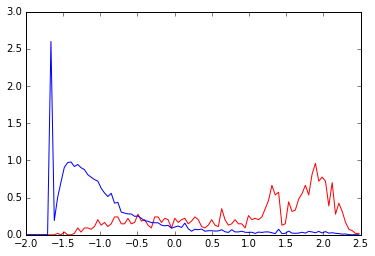

In [79]:
##plot score distribution of RBP proteins(Gerstberger's RBP list)(normalized, so that the area under the curve is 1)
heights_RBP, bins_RBP, patches=plt.hist(score_flag_df[score_flag_df['RBP_flag']==1]['avg.score'], bins=100, range=(-2.0,2.5), normed=True)
bins_RBP=0.5*(bins_RBP[:-1]+bins_RBP[1:])
##plot score distribution of non-RBP proteins (those not belong to Gerstberger's list)(normalized, so that the area under the curve is 1)
heights_nonRBP, bins_nonRBP, patches=plt.hist(score_flag_df[score_flag_df['RBP_flag']==0]['avg.score'], bins=100,range=(-2.0,2.5),normed=True)
bins_nonRBP=0.5*(bins_nonRBP[:-1]+bins_nonRBP[1:])
plt.clf()
plt.plot(bins_RBP,heights_RBP,'-',color='r')
plt.plot(bins_nonRBP, heights_nonRBP, '-')


<h2>Plotting the score distribution over all BioPlex proteins</h2>

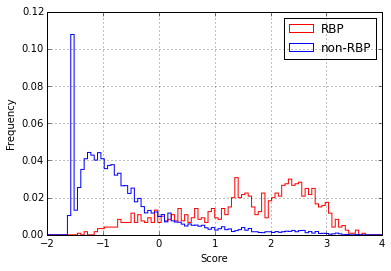

In [8]:
weights_RBP=np.ones(len(avg_Score_df[avg_Score_df['RBP_flag']==1]))/len(avg_Score_df[avg_Score_df['RBP_flag']==1])    #used in the following plt.hist() which will get the frequence of each bin rather than the counts of them.
weights_nonRBP=np.ones(len(avg_Score_df[avg_Score_df['RBP_flag']==0]))/len(avg_Score_df[avg_Score_df['RBP_flag']==0]) #used in the following plt.hist() which will get the frequence of each bin rather than the counts of them.
p1=avg_Score_df[avg_Score_df['RBP_flag']==1]['avg.score'].hist(bins=100, range=(-2,4.0), weights=weights_RBP, histtype='step', color='r', label='RBP')
p2=avg_Score_df[avg_Score_df['RBP_flag']==0]['avg.score'].hist(bins=100, range=(-2,4.0), weights=weights_nonRBP, histtype='step', color='b', label='non-RBP')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score distribution of Bioplex proteins with 2levelNB_svm_classifiers')
p1.legend()
p2.legend()
plt.savefig('Bioplex_Score_distribution_from_2levelNB_svm_weight2.0.pdf',format='pdf')

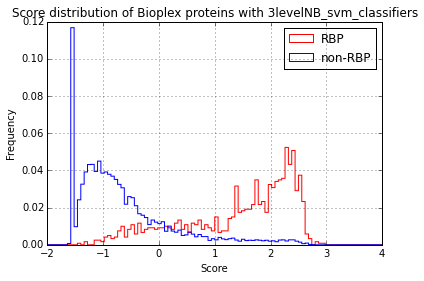

In [9]:
weights_RBP=np.ones(len(avg_Score_df[avg_Score_df['RBP_flag']==1]))/len(avg_Score_df[avg_Score_df['RBP_flag']==1])    #used in the following plt.hist() which will get the frequence of each bin rather than the counts of them.
weights_nonRBP=np.ones(len(avg_Score_df[avg_Score_df['RBP_flag']==0]))/len(avg_Score_df[avg_Score_df['RBP_flag']==0]) #used in the following plt.hist() which will get the frequence of each bin rather than the counts of them.
p1=avg_Score_df[avg_Score_df['RBP_flag']==1]['avg.score'].hist(bins=100, range=(-2,4.0), weights=weights_RBP, histtype='step', color='r', label='RBP')
p2=avg_Score_df[avg_Score_df['RBP_flag']==0]['avg.score'].hist(bins=100, range=(-2,4.0), weights=weights_nonRBP, histtype='step', color='b', label='non-RBP')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score distribution of Bioplex proteins with 3levelNB_svm_classifiers')
p1.legend()
p2.legend()
plt.savefig('Bioplex_Score_distribution_from_3levelNB_svm_weight2.0.pdf',format='pdf')

In [42]:
len(avg_Score_df[avg_Score_df['RBP_flag']==0])

9758

In [54]:
score_flag_df[score_flag_df['avg.score']<-1.65]

,avg.score,RBP_flag
A2LD1,-1.660127,0
AADAT,-1.660127,0
AASS,-1.660127,0
ABAT,-1.660127,0
ABCB5,-1.660127,0
ABCC1,-1.660127,0
ABHD12B,-1.660127,0
ABL1,-1.660127,0
ABTB2,-1.660127,0
ACADSB,-1.660127,0


In [22]:
##build 8 classifiers from our dataset,(it's 8, because we divide our non-RBP samples into 8 group for undersampling)
clf_list=[]
undersample_nonRBP=get_undersampled_nonRBPix_from_Bioplex(PPI_feature_label_mat)
for idx in undersample_nonRBP_idx:
    clf_SVM=svm.SVC(kernel= 'rbf', probability=False)  #use confidence score to describe each sample
    #clf_SVM=svm.SVC(kernel= 'rbf', probability=True)  #use probability as scores to describe each sample
    Xy_nonRBP_df_undersampled = Xy_nonRBP_df.iloc[idx]
    Xy_undersampled_df = pd.concat([Xy_RBP_df,Xy_nonRBP_df_undersampled])
    X_undersampled = np.array(Xy_undersampled_df[['primary_RBP_ratio','secondary_RBP_ratio']])
    y_undersampled = np.array(Xy_undersampled_df['RBP_flag'])
    Xy_undersampled_prot_names = Xy_undersampled_df.index
    clf_svm=clf_SVM.fit(X_undersampled, y_undersampled)
    clf_list.append(clf_svm)
    
#    cv = StratifiedKFold(y_undersampled, n_folds=10)
#    recall = 0
#    FPR = 0    
#    for train, test in cv:
#        test_prot_names=Xy_undersampled_prot_names[test]
#        y_pred=clf_SVM.fit(X_undersampled[train], y_undersampled[train]).predict(X_undersampled[test])
#        recall=recall+recall_score(y_undersampled[test], y_pred)
#        FPR=FPR+(1-get_specificity(y_undersampled[test], y_pred))

In [23]:
classification_scores=pd.DataFrame(index=X_prot_names)
clf_num=0
for clf in clf_list:
    clf_num=clf_num+1
    classification_scores[str(clf_num)]=clf.decision_function(X)    

In [48]:
score_flag_df=pd.concat([classification_scores.mean(axis=1),PPI_feature_label_mat['RBP_flag']],axis=1)
score_flag_df.columns=['avg.score','RBP_flag']

,avg.score,RBP_flag
1-Sep,-1.112607,0
10-Sep,-0.240118,0
11-Sep,0.536488,0
12-Sep,-1.235885,0
14-Sep,-1.302956,0
2-Sep,-0.065862,0
3-Sep,-0.144802,0
4-Sep,-1.358661,0
5-Mar,-0.851051,0
5-Sep,0.536488,0


In [39]:
classification_scores[classification_scores['6']!=classification_scores['2']]

,1,2,3,4,5,6,7,8
1-Sep,-1.143421,-1.087328,-1.105834,-1.096631,-1.087928,-1.089399,-1.114091,-1.176226
10-Sep,-0.229542,-0.220082,-0.210435,-0.220844,-0.235776,-0.236492,-0.236524,-0.331248
11-Sep,0.583223,0.553854,0.584560,0.562585,0.517756,0.519342,0.544956,0.425633
12-Sep,-1.269350,-1.210264,-1.231682,-1.222689,-1.209666,-1.212016,-1.236332,-1.295079
14-Sep,-1.337853,-1.277109,-1.300144,-1.291215,-1.275939,-1.278804,-1.302850,-1.359732
2-Sep,-0.048932,-0.046186,-0.032152,-0.043629,-0.065742,-0.065789,-0.062344,-0.162121
3-Sep,-0.135217,-0.123920,-0.113651,-0.119641,-0.141480,-0.141099,-0.144004,-0.239407
4-Sep,-1.394742,-1.332605,-1.357002,-1.348098,-1.331003,-1.334316,-1.358101,-1.413422
5-Mar,-0.876153,-0.826166,-0.838764,-0.828704,-0.829968,-0.829864,-0.854825,-0.923965
5-Sep,0.583223,0.553854,0.584560,0.562585,0.517756,0.519342,0.544956,0.425633


In [56]:
max_RBPscore=max(score_flag_df[score_flag_df['RBP_flag']==1]['avg.score'])
max_nonRBPscore=max(score_flag_df[score_flag_df['RBP_flag']==0]['avg.score'])
#score_flag_df['avg.score']
print max_RBPscore
print max_nonRBPscore

2.46998919242
2.43635821049


##Retrieve scores from BioPlex score list

In [10]:
Score_table = pd.read_table('Classification_3levelNB_scores_all_BioplexProteins.xls', index_col=0)

In [44]:
query_file = pd.ExcelFile('/home/wjin/Dropbox/RBP_identification_Kris_Wenhao/Files/Apex_project/G3BP-APEX candidates_sorted known vs novel.xlsx')
query_file2 = pd.ExcelFile('/home/wjin/Dropbox/RBP_identification_Kris_Wenhao/Files/Apex_project/15-09-23 SGproteins for validation.xlsx')
query_table = query_file.parse(query_file.sheet_names[0]).set_index('Gene Symbol')
query_set = set(query_file.parse(query_file.sheet_names[0])['Gene Symbol'])
query_set_available = query_set.intersection(Score_table.index)
query_table2 = query_file2.parse(query_file2.sheet_names[0]).set_index('Gene Symbol')
query_set2 = set(query_file2.parse(query_file2.sheet_names[0])['Gene Symbol'])
query_set2_available = query_set2.intersection(Score_table.index)

In [45]:
print len(query_set)
print len(query_set_available)
print len(query_set2)
print len(query_set2_available)

223
165
161
121


In [46]:
score_list1 = Score_table.loc[query_set_available]
score_table1 = query_table.join(score_list1, how='left')
score_list2 = Score_table.loc[query_set2_available]
score_table2 = query_table2.join(score_list2, how='left')
score_table1.to_csv('/home/wjin/Dropbox/RBP_identification_Kris_Wenhao/Files/Apex_project/G3BP-APEX_candidates_sorted_knownVSnovel_add_scores.xls', sep='\t')
score_table2.to_csv('/home/wjin/Dropbox/RBP_identification_Kris_Wenhao/Files/Apex_project/15-09-23_SGproteins_for_validation_add_scores.xls', sep='\t')

In [47]:
score_table2

,avg.score,RBP_flag
Gene Symbol,,
ATXN2L,1.818801,1
C21orf33,1.063406,0
CAPN2,-1.232363,0
CELF3,1.400742,1
CLPP,1.551996,0
EIF4H,NaN,NaN
HNRNPDL,NaN,NaN
IGF2BP2,1.377213,1
LYST,NaN,NaN
